# Preparing images for U-net architechture
### October 12th 2018
* This notebook takes annotated images that originally came from mm3 and prepares them to be used as training and validation data for a U-net convolution net. 
* Need to take tif stacks (raw images and masks), make them square, and make the masks binary images.
* Additionaly, can do morphological operations on the masks to clean them up. 
* Images are save to a directory tree.

In [29]:
from __future__ import print_function

import os
import tifffile as tiff
import png # can pip this package to save pngs at any bitsize
import numpy as np
from skimage import morphology # for editing images

# Plotting
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

# Load images
The data originally came from [this experiment](https://www.evernote.com/shard/s270/nl/69190255/8f3894ed-55c0-4514-bafa-5401846d9878/). 

This is how I annotated the images using imageJ.
* I use the phase _c1, subtracted phase _c1_sub, and segmented _seg images. 
* Turn the segmented image to a binary using Image>Adjust>Threshold, then change it back to 16-bit Image>Type>16-bit. 
* Then merge the channels Image>Color>Merge and make a composite image with phase in grey, subtracted in cyan, and threshold in yellow. Adjust colors with the levels menu so you can see all three. 
* Make sure you are on the 3rd (segmented) channel. Press Option + right arrow to move through the "Z stacks"/timepoints. 
* Edit images with the pencil tool. Break up all cells by at least 1 pixel.  
* Save the merged stack as fXXpXXXX_c1_comp3_annotate.tif
* After 50 time points for one channel, save individual channels. Use Image>Colors>Split Channels then Image>Stacks>Tools>Slice Keeps to save the slices you annotated. Save phase and segmented as as fXXpXXXX_1-50_img.tif and fXXpXXXX_1-50_mask.tif, respectively.

I loaded, processed, and saved each dataset one at a time rather than processing them all at once. 

In [30]:
image_source_path = './demo/annotated'

phase_images = 'f01p0030_1-50_img.tif'
mask_images = 'f01p0030_1-50_mask.tif'
id_str = 'f01p0030'

# phase_images = 'f01p0161_1-50_img.tif'
# mask_images = 'f01p0161_1-50_mask.tif'
# id_str = 'f01p0161'

# phase_images = 'f01p0248_1-50_img.tif'
# mask_images = 'f01p0248_1-50_mask.tif'
# id_str = 'f01p0248'

# phase_images = 'f01p0335_1-50_img.tif'
# mask_images = 'f01p0335_1-50_mask.tif'
# id_str = 'f01p0335'

In [31]:
with tiff.TiffFile(os.path.join(image_source_path, phase_images)) as tif:
    img_stack = tif.asarray()
    
with tiff.TiffFile(os.path.join(image_source_path, mask_images)) as tif:
    mask_stack = tif.asarray()

### What do they look like?

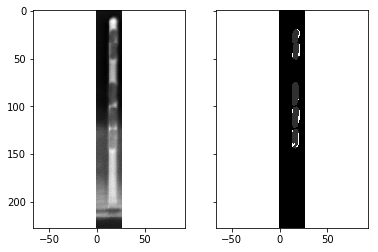

In [32]:
fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True)
ax = axes.ravel()
ax[0].imshow(img_stack[0], cmap=plt.cm.gray)
ax[1].imshow(mask_stack[0], cmap=plt.cm.gray)

# Make directory for images in correct format
The format is to look like:

```bash
./data/
├── train
│   ├── images
│   │   └── cells
│   └── masks
│       └── cells
└── val
    ├── images
    │   └── cells
    └── masks
        └── cells
```

* The `train` directory holds images and masks for training the model. 
* The `val` directory holds images and masks for validating the model (necessary for training). 
* The the images go into the extra directory 'cells' as this is the name of the label. You need this extra directory.

In [33]:
image_dest_path = './demo'

try:
    os.makedirs(os.path.join(image_dest_path, 'data/train/images/cells'))
except:
    print(os.path.join(image_dest_path, 'data/train/images/cells'), 'already exists.')
try:
    os.makedirs(os.path.join(image_dest_path, 'data/train/masks/cells'))
except:
    print(os.path.join(image_dest_path, 'data/train/masks/cells'), 'already exists.')
try:
    os.makedirs(os.path.join(image_dest_path, 'data/val/images/cells'))
except:
    print(os.path.join(image_dest_path, 'data/val/images/cells'), 'already exists.')
try:
    os.makedirs(os.path.join(image_dest_path, 'data/val/masks/cells'))
except:
    print(os.path.join(image_dest_path, 'data/val/masks/cells'), 'already exists.')

./demo/data/train/images/cells already exists.
./demo/data/train/masks/cells already exists.
./demo/data/val/images/cells already exists.
./demo/data/val/masks/cells already exists.


# Fix images and masks, and save
* Images of cells and masks must be square with a side length that is a power of 2. Specifically, the model is set up to take images that are 256x256. It can be, say, 128 or 512, but you'll need to change the model structure. 
* We will pad both images using edge padding. The phase images will be saved as 16-bit .pngs.
* Mask images should be actual binary images (0 or 1), and be saved as 8-bit .pngs. 
* You can erode the binary mask to make the separation between the cells a little stronger. But the model seems to work in either case. 
* Some images will be put in the folder to be used for training, the others will be used for model validation. I've seen everywhere from 90/10 to 50/50 split. Not sure what is best. There are 200 images total so I will put 10 from every set of 50 in the validation folder.

In [34]:
n_train = 40 # after this number images will be sent to the evaluation folder

In [35]:
for i in range(img_stack.shape[0]):
    # binarize and erode mask
    mask_img = mask_stack[i]
    mask_img[mask_img > 0] = 1
    
    # this square does a nice job of cutting off corners
#     mask_img = morphology.binary_erosion(mask_img, selem=morphology.disk(1))

    # reshape images
    shape = (256, 256)
    img_shape = mask_img.shape
    pad = ((np.ceil((shape[0] - img_shape[0])/2.0).astype(int), 
            np.floor((shape[0] - img_shape[0])/2.0).astype(int)),
           (np.ceil((shape[1] - img_shape[1])/2.0).astype(int), 
            np.floor((shape[1] - img_shape[1])/2.0).astype(int)))
    mask_img = np.pad(mask_img, pad_width=pad, mode='edge')

    phase_img = img_stack[i]
    img_shape = phase_img.shape
    pad = ((np.ceil((shape[0] - img_shape[0])/2.0).astype(int), 
            np.floor((shape[0] - img_shape[0])/2.0).astype(int)),
           (np.ceil((shape[1] - img_shape[1])/2.0).astype(int), 
            np.floor((shape[1] - img_shape[1])/2.0).astype(int)))
    phase_img = np.pad(phase_img, pad_width=pad, mode='edge')

    # save images
    if i < n_train:
        phase_file_path = os.path.join(image_dest_path, 'data/train/images/cells')
        mask_file_path = os.path.join(image_dest_path, 'data/train/masks/cells')
    else:
        phase_file_path = os.path.join(image_dest_path, 'data/val/images/cells')
        mask_file_path = os.path.join(image_dest_path, 'data/val/masks/cells')
        
    mask_name = id_str + '_mask_' + '{:02d}'.format(i+1) + '.png'
    with open(os.path.join(mask_file_path, mask_name), 'wb') as f:
        w = png.Writer(width=shape[1], height=shape[0], bitdepth=8, greyscale=True)
        w.write(f, mask_img)

    phase_name = id_str + '_phase_' + '{:02d}'.format(i+1) + '.png'
    with open(os.path.join(phase_file_path, phase_name), 'wb') as f:
        w = png.Writer(width=shape[1], height=shape[0], bitdepth=16, greyscale=True)
        w.write(f, phase_img)